#Part-of-Speech Tagging with LSTM#
##Introduction##
This project presents an end-to-end implementation of a Part-of-Speech (POS) tagging model using a Long Short-Term Memory (LSTM) neural network.

POS tagging involves assigning grammatical categories (such as noun and verb) to words in a given text. The model is developed using PyTorch and is trained on a dataset derived from the Penn Treebank.


---
##The main dataset:##
**Source:** The primary data source was the Billboard Year-End Hot 100 Singles USA, an annual ranking of the top-performing songs in the United States. It encompasses 5402 lyrics out of the 6889 songs from a diverse array of artists and genres

**Scope:** The dataset spans from 1946 to 2022, capturing the evolution of popular music over several decades. Notably, the first years of the ranking included less than 100 songs.

**Selection Criteria:** To ensure a representative dataset, at least the top 20 songs from each year were included. This criterion was applied to account for variations in the number of songs listed each year.


##1. Prepare the environment##

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk import word_tokenize
from nltk.corpus import treebank
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import random
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import requests
from io import StringIO


###1.1. Download NLTK Resources##

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('treebank')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

###1.2. Download the Penn Treebank dataset and converting it into a flat list.

The Penn Treebank is a corpus of English texts that has been annotated with syntactic and part-of-speech information.

In [ ]:
# Download the Penn Treebank dataset
treebank_data = treebank.tagged_sents()

# Convert the data into a flat list of (word, POS) tuples
tagged_words = [(word, tag) for sentence in treebank_data for word, tag in sentence]

# Split the data into train and test sets
train_data, test_data = train_test_split(tagged_words, test_size=0.2, random_state=42)

# Preprocess the data and create a vocabulary
all_words = [word for word, _ in tagged_words]
word_counts = Counter(all_words)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.most_common())}

##2. Model Architecture##

LSTM networks are a type of recurrent neural network (RNN) designed to overcome the limitations of traditional RNNs when handling sequential data. They introduce memory cells and gating mechanisms that allow the model to selectively remember or forget information over long sequences.


###2.1. Definition of the LSTM-based POS tagging model.###

Embedding Layer
- Responsible for transforming input word indices into dense vectors of fixed size.
- Utilizes an embedding matrix to capture semantic relationships between words.

LSTM Layer
- The LSTM layer is set to be bidirectional, allowing the model to consider contextual information from both past and future words.

Fully Connected Layer
- A linear layer (fully connected) that maps the output of the LSTM layer to the desired output dimension, corresponding to the number of POS tags.
- Activation function and dropout are applied to enhance the model's generalization.


In [ ]:
# Map POS tags to indices
tag_to_idx = {tag: idx for idx, (word, tag) in enumerate(set(tagged_words))}

# Map POS tags to indices
tag_to_idx = {tag: idx for idx, tag in enumerate(set(tag for _, tag in tagged_words))}

In [ ]:
# Define a simple LSTM-based POS tagging model
class PosTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(PosTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)  # Set bidirectional to True
        self.fc = nn.Linear(2 * hidden_dim, output_dim)  # Multiply hidden_dim by 2 for bidirectional LSTM
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        output = self.fc(lstm_out)
        return output

# Create PyTorch datasets and dataloaders
class PosDataset(Dataset):
    def __init__(self, data, vocab, tag_to_idx):
        self.data = data
        self.vocab = vocab
        self.tag_to_idx = tag_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word, tag = self.data[idx]
        word_idx = self.vocab.get(word, 0)  # Use 0 for unknown words
        tag_idx = self.tag_to_idx[tag]
        return word_idx, tag_idx


##3. Model Training##


During training, the model aims to minimize the cross-entropy loss.

Cross-entropy is a measure of the dissimilarity between the predicted probability distribution and the true distribution (one-hot encoded ground truth).

**Hyperparameters:**
- **Vocabulary Size:** The size of the vocabulary, determined by the unique words in the training dataset.
- **Embedding Dimension:** The size of the word embeddings. Determines how words are represented in the model's vector space, influencing semantic relationships.
- **Hidden Dimension:** The size of the hidden state in the LSTM layer.Defines the capacity of the model to capture complex patterns.
-**Output Dimension:** The number of distinct POS tags.
- **Dropout Rate:** A regularization technique applied to the fully connected layer during training. Acts as a regularization technique, preventing overfitting.

The model is trained using the Adam optimizer, and a learning rate scheduler is employed to adapt the learning rate during training epochs.

###3.1. Instantiate the model, loss function, and optimizer

In [ ]:
# Instantiate the model, loss function, and optimizer
vocab_size = len(vocab) + 1  # Add 1 for unknown words
embedding_dim = 50
hidden_dim = 100
output_dim = len(tag_to_idx)
model = PosTagger(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.010)

###3.2. Create PyTorch datasets and data loaders###

In [ ]:
# Create DataLoader instances
batch_size = 32
train_dataset = PosDataset(train_data, vocab, tag_to_idx)
test_dataset = PosDataset(test_data, vocab, tag_to_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


###3.3. Training process, including the training loop###

In [ ]:
epochs = 5

# Lists to store training and validation loss values
train_losses = []
val_losses = []

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Train the model
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)

    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for words, tags in train_loader:
            words, tags = words.to(device), tags.to(device)  # Move data to GPU
            optimizer.zero_grad()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            outputs = model(words)
            loss = criterion(outputs.view(-1, output_dim), tags.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix({'Loss': total_loss / (pbar.n + 1)})

    scheduler.step()  # Update learning rate

    # Record training loss
    train_losses.append(total_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        num_val_batches = len(test_loader)

        for words, tags in test_loader:
            words, tags = words.to(device), tags.to(device)  # Move data to GPU
            outputs = model(words)
            val_loss = criterion(outputs.view(-1, output_dim), tags.view(-1))
            total_val_loss += val_loss.item()

        # Record validation loss
        val_losses.append(total_val_loss / num_val_batches)

# Save the trained model
torch.save(model.state_dict(), 'pos_tagger_model.pth')

Epoch 5/5: 100%|██████████| 2517/2517 [00:52<00:00, 47.88batch/s, Loss=0.264]


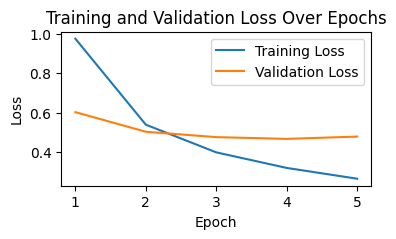

In [ ]:
# Plot the learning curve
plt.figure(figsize=(4, 2))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


##4. Model evaluation##

###4.1. Evaluate the model on the test set###

In [ ]:
# Evaluate the model on the test set
model.eval()
all_preds = []
all_labels = []

for words, tags in test_loader:
    with torch.no_grad():
        outputs = model(words)
    _, preds = torch.max(outputs, dim=-1)  # Use dim=-1 to get the indices along the last dimension
    all_preds.extend(preds.view(-1).numpy())
    all_labels.extend(tags.view(-1).numpy())

Accuracy: 0.8777810885975368
Precision: 0.8792202884013243
Recall: 0.8777810885975368
F1 Score: 0.8752276396867669


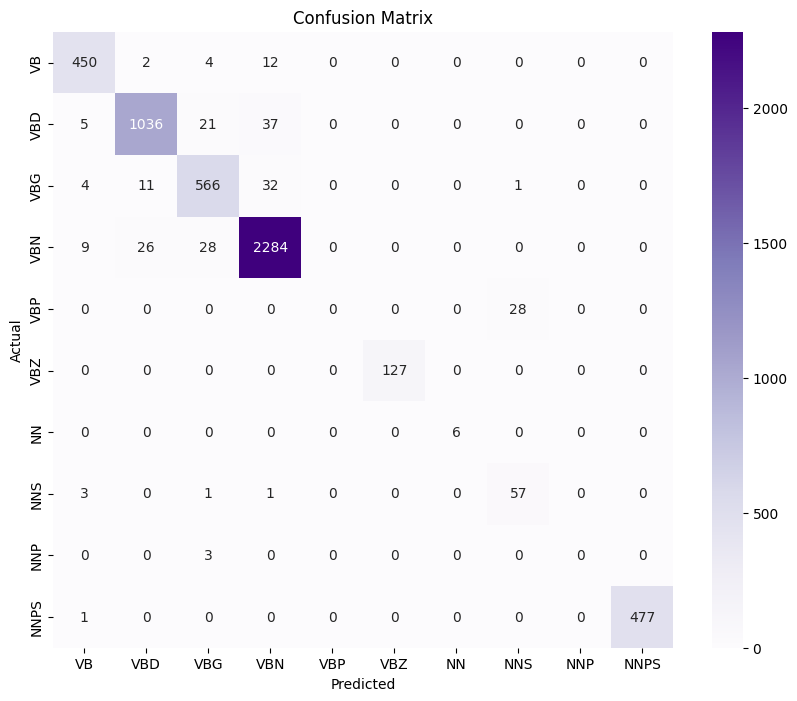

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Define POS tags
pos_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NN', 'NNS', 'NNP', 'NNPS']

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(pos_tags)))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=pos_tags, yticklabels=pos_tags)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##5. Apply to the Billboard Charts Dataset##

###5.1. Load and preprocess the dataset###

In [ ]:
# Load the Billboard's top 100 charts dataset
# chart_data = pd.read_csv('chart_data.csv')

github_raw_link = 'https://raw.githubusercontent.com/isabelasaenz/POS-LSTM/main/chart_data.csv'
response = requests.get(github_raw_link)
data = StringIO(response.text)
chart_data = pd.read_csv(data)

In [ ]:
# Drop rows without lyrics
chart_data = chart_data.dropna(subset=['lyrics'])

# Preprocess the lyrics data
stop_words = set(stopwords.words('english'))

def preprocess_lyrics(lyrics):
    words = word_tokenize(lyrics.lower())
    words = [word for word in words if "'" not in word]
    words = [word for word in words if len(word) >= 3]

    non_descriptive_words = ['yeah', 'hey', 'oh', 'la', 'na', 'ah', 'ooh', 'whoa']  # Add more as needed

    filtered_words = [word for word in words if word.isalpha() and word not in stop_words and word not in non_descriptive_words]

    return filtered_words


###5.2. Apply the POS-tagging model to the lyrics data##

In [ ]:
# Apply the POS-tagging model to the lyrics data
chart_data['relevant_words'] = chart_data['lyrics'].apply(preprocess_lyrics)

# Convert relevant words to POS tags using the PyTorch model
def words_to_tags(words):
    indices = [vocab.get(word, 0) for word in words]
    with torch.no_grad():
        inputs = torch.tensor(indices).unsqueeze(0)
        outputs = model(inputs)
    _, preds = torch.max(outputs, dim=-1)

    # Convert predicted indices to POS tags
    tags = [list(tag_to_idx.keys())[idx] for idx in preds.view(-1).numpy()]
    return tags

# Apply the POS-tagging model to the lyrics data
chart_data['predicted_tags'] = chart_data['relevant_words'].apply(words_to_tags)

# Display the processed data
print(chart_data[['title', 'artist', 'year', 'relevant_words', 'predicted_tags']])

                                               title  \
0                           Circles Around This Town   
1                                    I Ain’t Worried   
2                                          You Proof   
3                                          Bad Habit   
4                                            Sunroof   
...                                              ...   
6884                         They Say It's Wonderful   
6885                               Hey! Ba-Ba-Re-Bop   
6886  Laughing on the Outside (Crying on the Inside)   
6887                               Five Minutes More   
6888                                Prisoner of Love   

                                          artist  year  \
0                                   Maren Morris  2022   
1                                    OneRepublic  2022   
2                                  Morgan Wallen  2022   
3                                     Steve Lacy  2022   
4                           Nicky You

##6. Analysis##

###6.1. Word Category Analysis Over Time##
- Extract relevant words and predicted POS tags
- Count and display top words in each category per decade.

Analyzing word category trends over time can provide insights into linguistic evolution. The model's predictions allow us to observe how the usage of verbs and nouns in song lyrics has changed across decades, reflecting broader societal and cultural shifts.

In [ ]:
# Extract relevant words and predicted POS tags
relevant_words_tags = chart_data[['year', 'relevant_words', 'predicted_tags']]

# Initialize counters
verb_counters = {decade: Counter() for decade in range(1940, 2030, 10)}
noun_counters = {decade: Counter() for decade in range(1940, 2030, 10)}

# Define POS tags for verbs and nouns
verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']

# Iterate through the DataFrame and count POS tags
for _, row in relevant_words_tags.iterrows():
    year = row['year']
    words = row['relevant_words']
    tags = row['predicted_tags']

    decade = (year // 10) * 10  # Group into decades

    # Count occurrences per word category
    for word, tag in zip(words, tags):
        if tag in verb_tags:
            verb_counters[decade][word] += 1
        elif tag in noun_tags:
            noun_counters[decade][word] += 1

# Display the words with the most occurrences for each category per decade
for decade in range(1940, 2030, 10):
    print(f"\nDecade: {decade}s")

    top_verbs = verb_counters[decade].most_common(5)
    print("\nTop Verbs:")
    for word, count in top_verbs:
        print(f"{word}: {count} occurrences")

    top_nouns = noun_counters[decade].most_common(5)
    print("\nTop Nouns:")
    for word, count in top_nouns:
        print(f"{word}: {count} occurrences")



Decade: 1940s

Top Verbs:
know: 90 occurrences
let: 84 occurrences
come: 53 occurrences
say: 50 occurrences
make: 49 occurrences

Top Nouns:
heart: 106 occurrences
love: 91 occurrences
night: 54 occurrences
day: 47 occurrences
sky: 46 occurrences

Decade: 1950s

Top Verbs:
come: 227 occurrences
know: 215 occurrences
say: 170 occurrences
let: 155 occurrences
got: 141 occurrences

Top Nouns:
love: 247 occurrences
heart: 241 occurrences
baby: 212 occurrences
day: 133 occurrences
time: 121 occurrences

Decade: 1960s

Top Verbs:
know: 722 occurrences
got: 709 occurrences
come: 586 occurrences
let: 483 occurrences
see: 452 occurrences

Top Nouns:
baby: 1161 occurrences
love: 640 occurrences
time: 456 occurrences
heart: 359 occurrences
girl: 357 occurrences

Decade: 1970s

Top Verbs:
got: 1034 occurrences
know: 916 occurrences
get: 792 occurrences
come: 625 occurrences
let: 608 occurrences

Top Nouns:
baby: 928 occurrences
love: 795 occurrences
time: 577 occurrences
way: 553 occurrences
nigh

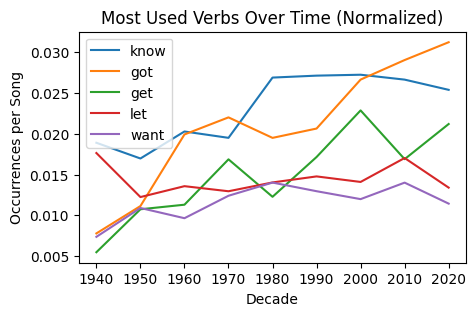

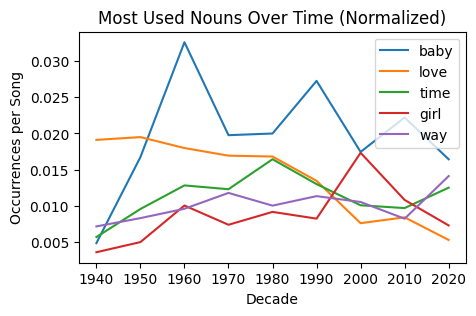

In [ ]:
# Aggregate counts for each word category and total number of songs per decade
overall_verbs = Counter()
overall_nouns = Counter()
total_songs_per_decade = Counter()

for decade in range(1940, 2030, 10):
    overall_verbs.update(verb_counters[decade])
    overall_nouns.update(noun_counters[decade])

    # Calculate total number of songs per decade
    total_songs_per_decade[decade] = sum(verb_counters[decade].values()) + sum(noun_counters[decade].values())

# Normalize counts by the total number of songs per decade
normalized_verbs = {decade: {word: count / total_songs_per_decade[decade] for word, count in verb_counters[decade].items()} for decade in range(1940, 2030, 10)}
normalized_nouns = {decade: {word: count / total_songs_per_decade[decade] for word, count in noun_counters[decade].items()} for decade in range(1940, 2030, 10)}

# Get the most common normalized words for each category overall
top_normalized_verbs = overall_verbs.most_common(5)
top_normalized_nouns = overall_nouns.most_common(5)

# Plotting
def plot_category_over_time(category_counters, top_words, category_name):
    plt.figure(figsize=(5, 3))

    for word, _ in top_words:
        counts = [category_counters[decade][word] for decade in range(1940, 2030, 10)]
        plt.plot(range(1940, 2030, 10), counts, label=word)

    plt.xlabel('Decade')
    plt.ylabel('Occurrences per Song')
    plt.title(f'Most Used {category_name}s Over Time (Normalized)')
    plt.legend()
    plt.show()

plot_category_over_time(normalized_verbs, top_normalized_verbs, 'Verb')
plot_category_over_time(normalized_nouns, top_normalized_nouns, 'Noun')


###6.2. Sentiment Analysis###
- Perform sentiment analysis using TextBlob to determine the sentiment polarity of text
- Scatter plot for sentiments

In [ ]:
# Perform sentiment analysis using TextBlob
def analyze_sentiment(lyrics):
    blob = TextBlob(lyrics)
    sentiment = blob.sentiment.polarity
    return sentiment

# Apply sentiment analysis to the lyrics data
chart_data['sentiment'] = chart_data['lyrics'].apply(lambda x: analyze_sentiment(x))

In [ ]:
# Scatter plot for sentiments
fig = px.scatter(chart_data, x='year', y='sentiment', color='sentiment',
                 hover_data=['title', 'artist'], title='Sentiments Over Years')

fig.update_layout(xaxis_title='Year', yaxis_title='Sentiment', coloraxis_colorbar=dict(title='Sentiment'))
fig.show()

###6.3. Artist Analysis###
- Count artist frequency and calculating average sentiment.
- Creating a horizontal bar chart for artist frequency and average sentiment

In [ ]:
# Count the frequency of each artist or band
artist_frequency = chart_data['artist'].value_counts().head(10)

# Calculate average sentiment for each artist or band
artist_sentiment = chart_data.groupby('artist')['sentiment'].mean().loc[artist_frequency.index]

# Create a horizontal bar chart
fig = px.bar(x=artist_frequency.values, y=artist_frequency.index,
             color=artist_sentiment, orientation='h',
             labels={'x': 'Frequency', 'y': 'Artist'},
             title='Artist Frequency and Average Sentiment')

fig.update_layout(coloraxis_colorbar=dict(title='Average Sentiment'))
fig.show()

###6.4. Lyrics Length Analysis###
- Calculate the length of lyrics and average length per year
- Create a filled area plot for average length of lyrics over the years

In [ ]:
# Calculate the length of lyrics (number of words) for each song
chart_data['lyrics_length'] = chart_data['lyrics'].apply(lambda x: len(word_tokenize(x)))

# Calculate the average length of lyrics per year
average_length_by_year = chart_data.groupby('year')['lyrics_length'].mean().reset_index()

# Create a filled area plot for average length of lyrics per year
color_scale = px.colors.sequential.Plasma
fig = px.area(average_length_by_year, x='year', y='lyrics_length',
              labels={'x': 'Year', 'y': 'Average Length of Lyrics'},
              title='Average Length of Lyrics (Number of Words) Over the Years',
              color_discrete_sequence=color_scale)

fig.update_layout(showlegend=False)
fig.show()

### Sources ###

1. [Penn Treebank POS](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
2. [NLP Tutorial](https://github.com/graykode/nlp-tutorial)
3. [Open Source NLP Models for Sentiment Analysis](https://medium.com/@vishwanathmuthuraman_92476/open-source-nlp-models-for-sentiment-analyis-6e42665ee55a)
4. [POS Tagging with HMM and LSTM](https://medium.com/@yijiaz_58213/pos-tagging-with-hmm-and-lstm-538b4f74b037)
5. [NLTK Book - Chapter 5](https://www.nltk.org/book/ch05.html)
6. [PyTorch LSTM Documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
7. [PyTorch Sequence Models Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
8. [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
